In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib.colors import ListedColormap

IS_DARK = False
theme, cs = rp.mpl_setup(IS_DARK)

In [3]:
df = pd.read_feather('logs/12345.feather')
df.head()

,comp_ind,e_form,group_num,volume_ratio,lattice_type,wyckoff_letters,total_dof,i,comp,group_symbol
0,0,-5.328977,126,1.17021,tetragonal,e_b_e,2,1,Bi2Ce4O4,P4/nnc
1,1,-5.155964,126,1.17021,tetragonal,e_b_e,2,1,Bi2Ce4O4,P4/nnc
2,2,-5.348216,126,1.17021,tetragonal,e_b_e,2,1,Bi2Ce4O4,P4/nnc
3,3,-5.455560,126,1.17021,tetragonal,e_b_e,2,1,Bi2Ce4O4,P4/nnc
4,4,-5.431657,126,1.17021,tetragonal,e_b_e,2,1,Bi2Ce4O4,P4/nnc


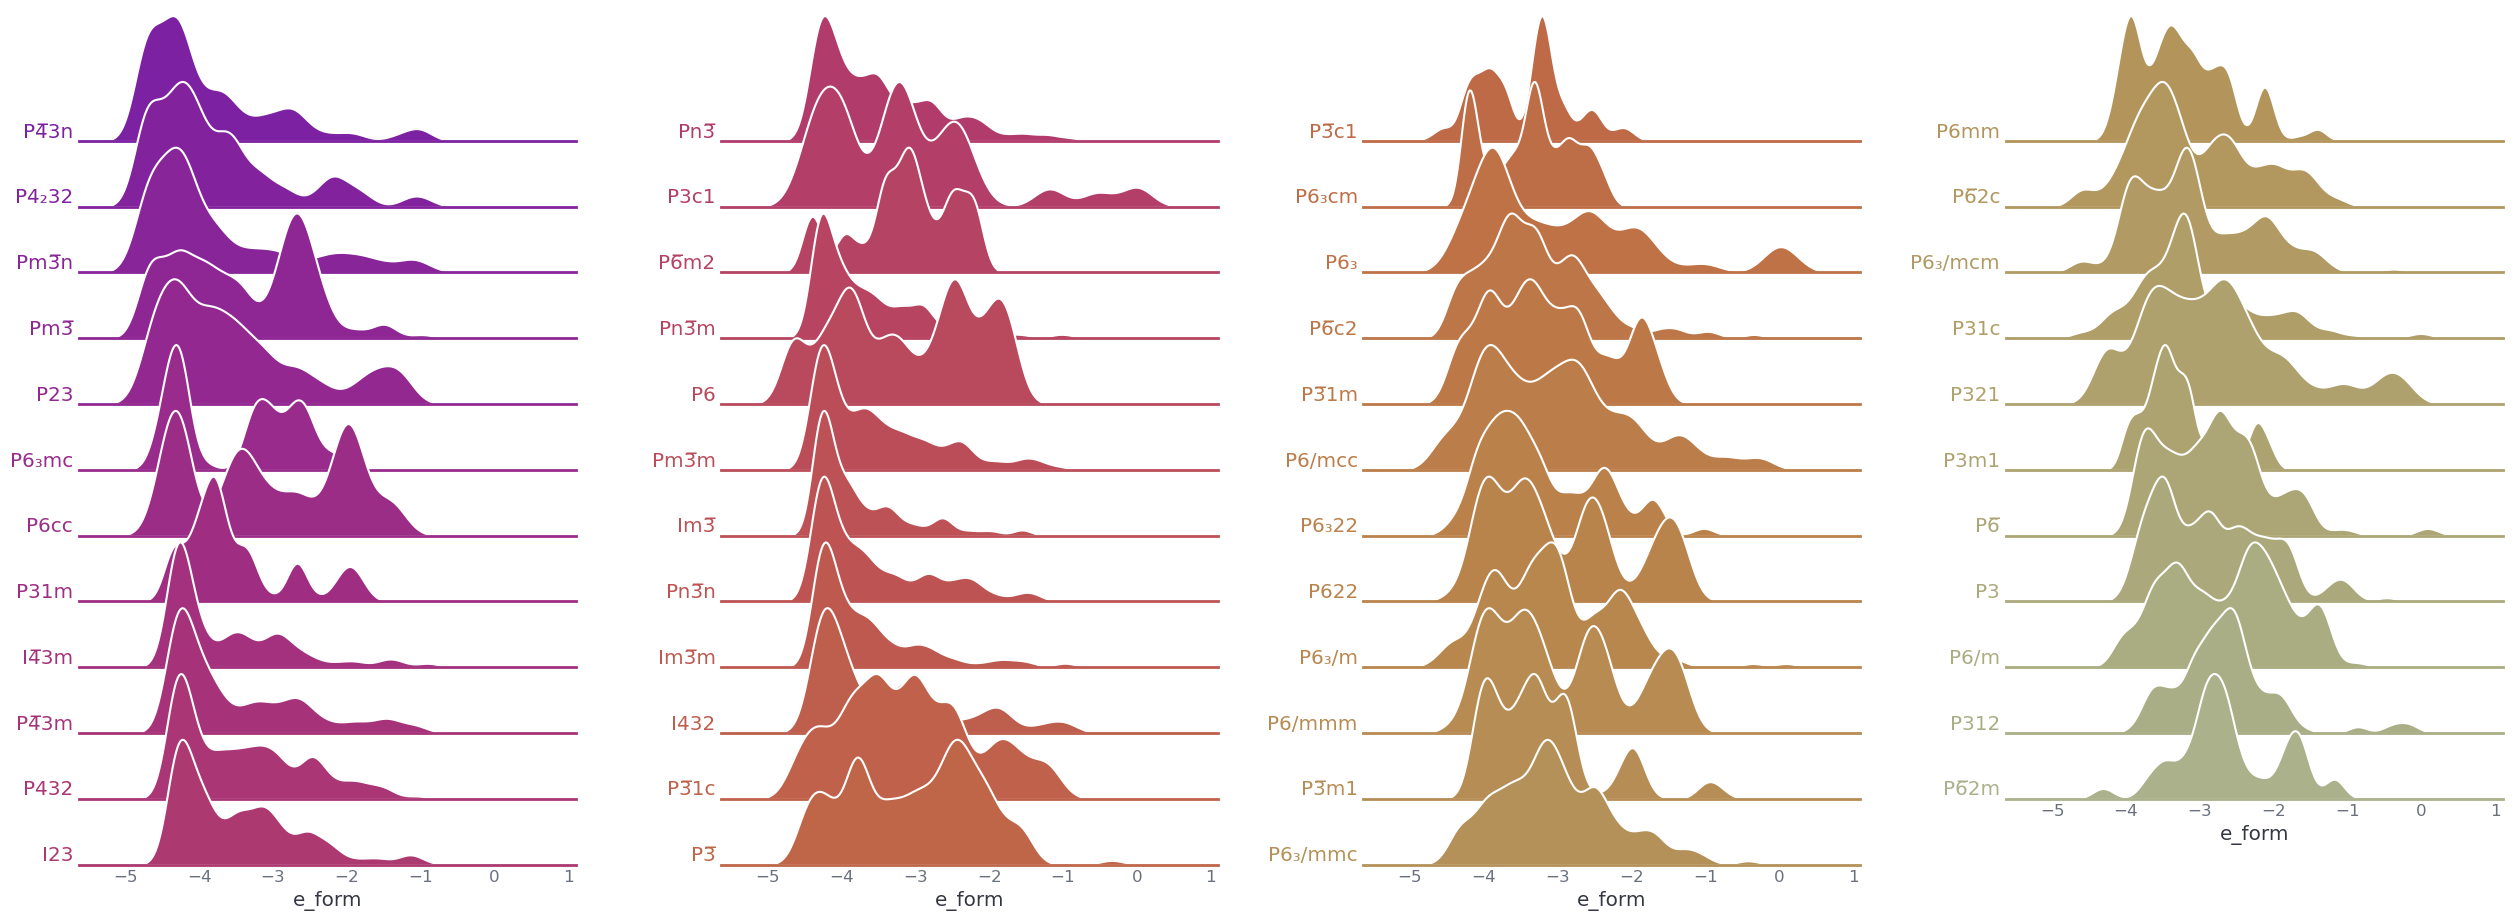

In [4]:
from baysic.viz import ridge_plot

ridge_plot(df.query('comp == "La2Pm6" and (lattice_type == "cubic" or lattice_type == "hexagonal")'), 'group_symbol', 'e_form', height=5)

In [5]:
import torch
def make_Xy(df):
    X = torch.tensor(np.hstack([
        df[['comp']].rank(method='dense').astype(int),
        df[['group_num']].rank(method='dense').astype(int),
    ])).long()
    y = torch.tensor(df['e_form'].values).float()

    return (X, y,
    sorted(set(df['comp'])),
    sorted(set(df['group_num'])))

test_comps = sorted([
    'La2Pm6', 'La2Tb6', 'Pb8Rh4', 'La10Pb6Zn2'
])
small_df = df.query('comp in @test_comps and comp_ind < 15 and (lattice_type == "cubic" or lattice_type == "hexagonal")')
X, y, comps, groups = make_Xy(df.query('(lattice_type == "cubic" or lattice_type == "hexagonal")'))
y_scaled = (y - y.mean()) / y.std()
print(len(set(X[:, 0].cpu().numpy())), 'comps')
print(len(set(X[:, 1].cpu().numpy())), 'groups')
print(X[::len(X)//5])
X.shape, y.shape

369 comps
85 groups
tensor([[100,  46],
        [122,  21],
        [165,   1],
        [  7,  16],
        [326,  12],
        [ 59,  65]])


(torch.Size([2024642, 2]), torch.Size([2024642]))

In [154]:
import torch
from torch.nn import functional as F
import pyro
import pyro.nn as nn
import pyro.distributions as dist
from pyro.contrib import gp
from baysic.utils import debug_shapes
from pyro import poutine
import logging

logging.basicConfig(level=logging.DEBUG, force=True)

In [155]:
from pyro.ops.indexing import Vindex
class Encoder(nn.PyroModule):
    def __init__(
        self,
        X: torch.LongTensor,
        y: torch.FloatTensor,
        num_clusters: int = 3,
        latent_dim: int = 32):
        super().__init__()
        self.num_compositions, self.num_groups = X.max(axis=0).values + 1
        self.num_clusters = num_clusters
        self.latent_dim = latent_dim
        self.group_latents = nn.PyroSample(
            dist.MultivariateNormal(
                torch.zeros(latent_dim),
                torch.eye(latent_dim)
            ).expand([self.num_groups, self.num_clusters]).to_event(2))

    def forward(self, X, cluster_i=None):
        if cluster_i is None:
            print('Filling in random indices!')
            cluster_i = torch.randint_like(X[..., [0]], 3)
        X_comps, X_groups = X[..., 0], X[..., 1]
        cluster_i = cluster_i[..., 0]

        group_mu = self.group_latents
        debug_shapes('group_mu', 'X_groups', 'cluster_i')

        data_pts = Vindex(group_mu)[..., X_groups, cluster_i, :]
        debug_shapes('data_pts')
        return data_pts

enc = Encoder(X, y)
print(enc(X[::1000], torch.arange(3)[:, None, None]).shape, '\n')

DEBUG:root: group_mu =   86    3   32
DEBUG:root: X_groups =           2025
DEBUG:root:cluster_i =         3    1
DEBUG:root:data_pts =    3 2025   32


torch.Size([3, 2025, 32]) 



In [188]:
import gpytorch

logging.basicConfig(level=logging.DEBUG, force=True)

class PVGPRegressionModel(gpytorch.models.PyroVariationalGP):
    def __init__(self, latent_dim, num_inducing=32, name_prefix="gp"):
        self.name_prefix = name_prefix

        # Define all the variational stuff
        inducing_points = torch.randn(num_inducing, latent_dim)
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points,
            gpytorch.variational.CholeskyVariationalDistribution(
                num_inducing_points=num_inducing)
        )

        # Standard initializtation
        super().__init__(variational_strategy)

        # Mean, covar, likelihood
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

    def guide(self, x, y):
        # Get q(f) - variational (guide) distribution of latent function
        function_dist = self.pyro_guide(x)

        # Use a plate here to mark conditional independencies
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # Sample from latent function distribution
            pyro.sample(self.name_prefix + ".f(x)", function_dist)

    def model(self, x, y):
        pyro.module(self.name_prefix + ".gp", self)

        # Get p(f) - prior distribution of latent function
        function_dist = self.pyro_model(x)

        # Use a plate here to mark conditional independencies
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # Sample from latent function distribution
            return pyro.sample(self.name_prefix + ".f(x)", function_dist, obs=y)


class BaysicGPR(nn.PyroModule):
    def __init__(self, X, y, num_clusters: int = 3, latent_dim: int = 2):
        super().__init__()
        self.num_clusters = num_clusters
        self.latent_dim = latent_dim * num_clusters
        self.num_compositions, self.num_groups = X.max(axis=0).values + 1
        self.X = X
        self.y = y
        self.encoder = Encoder(X, y, num_clusters=num_clusters, latent_dim=latent_dim)
        self.variance = nn.PyroSample(dist.Uniform(0.5, 10))
        self.gp = PVGPRegressionModel(self.latent_dim, 32)
        self.group_mu = nn.PyroSample(dist.MultivariateStudentT(4, torch.zeros(latent_dim), torch.eye(latent_dim)))
        self.comp_mu = nn.PyroSample(dist.MultivariateStudentT(4, torch.zeros(latent_dim), torch.eye(latent_dim)))
        self.concentration = nn.PyroSample(dist.Uniform(0.4, 3))
        self.w = nn.PyroSample(lambda self: dist.Dirichlet(torch.ones(num_clusters) * self.concentration))

    def forward(self, comp_batch=None, group_batch=None, condition=False):
        if comp_batch is None:
            comp_batch = torch.randint(0, self.num_compositions, [3])
        if group_batch is None:
            group_batch = torch.randint(0, self.num_groups, [10])

        concentration = self.concentration
        w = self.w
        with pyro.plate('group', self.num_groups, dim=-1):
            with pyro.plate('cluster', self.num_clusters, dim=-2):
                group_mu = self.group_mu

        debug_shapes('w', 'group_mu')

        with pyro.plate('composition', self.num_compositions, subsample=comp_batch) as comp_i:
            mask = torch.isin(self.X[:, 0], comp_i)
            comp_X = self.X[mask, 1]
            comp_y = self.y[mask]
            comp_groups = torch.unique(comp_X)
            with pyro.plate('data_groups', len(comp_groups), subsample=group_batch) as group_i:
                mask = torch.isin(comp_X, group_i)
                X = comp_X[mask]
                y = comp_y[mask]
                uniq, idx, counts = torch.unique(comp_X[mask], sorted=True, return_inverse=True, return_counts=True)

                _, ind_sorted = torch.sort(idx, stable=True)
                cum_sum = counts.cumsum(0)
                cum_sum = torch.cat((torch.tensor([0]), cum_sum[:-1]))
                first_indices = ind_sorted[cum_sum]

                uniq_X = uniq
                uniq_y = y[first_indices]

                debug_shapes('comp_X', 'X', 'y', 'w', 'uniq_X', 'uniq_y')

                X_latent = torch.flatten(Vindex(group_mu)[:, uniq_X, :], -2)
                debug_shapes('X_latent')


        w_coef = torch.reciprocal(torch.repeat_interleave(w, self.latent_dim // self.num_clusters))
        true_obs = pyro.sample('true_obs', self.gp(X_latent * w_coef))
        X_mask = torch.where(torch.isin(self.X[:, 0], comp_i) & torch.isin(self.X[:, 1], group_i))[0]
        mu = torch.ones(self.X.size(0))
        debug_shapes('mu', 'X_mask')
        mu = torch.scatter(mu, 0, X_mask, true_obs[idx])
        y_obs = torch.ones(self.X.size(0)) * torch.nan
        y_obs = torch.scatter(y_obs, 0, X_mask, y[idx])

        variance = self.variance
        debug_shapes('mu')
        with pyro.plate('data', self.X.size(0)):
            return pyro.sample('obs', dist.NanMaskedNormal(
                mu,
                torch.ones_like(mu) * variance,
            ), obs=y_obs if condition else None)

gpr = BaysicGPR(X, y_scaled)

gpr().shape

DEBUG:root:       w =        3
DEBUG:root:group_mu =  3 86  2
DEBUG:root:comp_X = 14919
DEBUG:root:     X =  2058
DEBUG:root:     y =  2058
DEBUG:root:     w =     3
DEBUG:root:uniq_X =     6
DEBUG:root:uniq_y =     6
DEBUG:root:X_latent = 6 6
DEBUG:root:    mu = 2024642
DEBUG:root:X_mask =    2058
DEBUG:root:mu = 2024642


torch.Size([2024642])

DEBUG:root:       w =        3
DEBUG:root:group_mu =  3 86  2
DEBUG:root:comp_X = 18440
DEBUG:root:     X =  2006
DEBUG:root:     y =  2006
DEBUG:root:     w =     3
DEBUG:root:uniq_X =     5
DEBUG:root:uniq_y =     5
DEBUG:root:X_latent = 5 6
DEBUG:root:    mu = 2024642
DEBUG:root:X_mask =    2006
DEBUG:root:mu = 2024642
DEBUG:graphviz.backend.execute:run [PosixPath('dot'), '-Kdot', '-Tsvg']


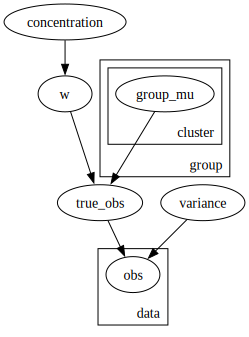

In [189]:
trace = poutine.trace(gpr)

pyro.render_model(gpr)

In [190]:
from pyro.infer import MCMC, NUTS

nuts = NUTS(gpr)
mcmc = MCMC(nuts, 100)

mcmc.run()

Warmup:   0%|          | 0/200 [01:25, ?it/s]
DEBUG:root:       w =        3
DEBUG:root:group_mu =  3 86  2
DEBUG:root:comp_X = 18440
DEBUG:root:     X =  2006
DEBUG:root:     y =  2006
DEBUG:root:     w =     3
DEBUG:root:uniq_X =     5
DEBUG:root:uniq_y =     5
DEBUG:root:X_latent = 5 6
DEBUG:root:    mu = 2024642
DEBUG:root:X_mask =    2006
DEBUG:root:mu = 2024642
DEBUG:root:       w =        3
DEBUG:root:group_mu =  3 86  2
DEBUG:root:comp_X = 13130
DEBUG:root:     X =  2805
DEBUG:root:     y =  2805
DEBUG:root:     w =     3
DEBUG:root:uniq_X =     6
DEBUG:root:uniq_y =     6
DEBUG:root:X_latent = 6 6
DEBUG:root:    mu = 2024642
DEBUG:root:X_mask =    2805
DEBUG:root:mu = 2024642
DEBUG:root:       w =        3
DEBUG:root:group_mu =  3 86  2
DEBUG:root:comp_X = 15815
DEBUG:root:     X =  1225
DEBUG:root:     y =  1225
DEBUG:root:     w =     3
DEBUG:root:uniq_X =     6
DEBUG:root:uniq_y =     6
DEBUG:root:X_latent = 6 6
DEBUG:root:    mu = 2024642
DEBUG:root:X_mask =    1225
DEBUG:

RuntimeError: The size of tensor a (6) must match the size of tensor b (5) at non-singleton dimension 0

In [184]:
from tqdm import tqdm
from pyro.infer import autoguide, SVI
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO, force=True)

torch.manual_seed(234)

num_epochs = 50

pyro.get_param_store().clear()

gpr = BaysicGPR(X, y_scaled, num_clusters=3, latent_dim=2)

guide = autoguide.AutoGuideList(gpr)
guide.append(autoguide.AutoDelta(gpr))
# guide.append(gpr.gp.guide)


lr1 = 5e-2
lr2 = 1e-2
lrd = (lr2 / lr1) ** (1 / num_epochs)
gpr_opt = pyro.optim.ClippedAdam(dict(lr=lr1, lrd=lrd))
loss_fn = pyro.infer.Trace_ELBO(max_plate_nesting=2)

svi = SVI(gpr, guide, gpr_opt, loss_fn)

losses = []
with tqdm(total=num_epochs) as bar:
    for i in range(num_epochs):
        comp_i = torch.randperm(len(comps))
        group_i = torch.randperm(len(groups))
        loss = 0
        for comp_batch in torch.chunk(comp_i, len(comp_i) // 2):
            for group_batch in torch.chunk(group_i, len(group_i) // 4):
                gpr.comp_batch = comp_batch
                gpr.group_batch = group_batch
                gp_loss = svi.step(condition=True)
                loss += gp_loss

        loss = loss / y.numel()
        losses.append(loss)
        bar.set_description('{:.3f}'.format(loss))
        bar.update()

def loss_plot(losses):
    """Smart plot for loss curves."""
    losses = np.asanyarray(losses)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    if losses.min() < 0:
        fig.set_title('{:.3f}'.format(losses.min()))
        losses += losses.min()

    ax1.plot(losses)
    inds = np.arange(len(losses))[-len(losses)//4:]
    ax2.plot(inds, losses[inds])
    ax1.set_ylim(0, None)
    ax2.set_ylim(0, ax2.get_ylim()[1] * 1.2)

loss_plot(losses)

  0%|          | 0/50 [00:00<?, ?it/s]


AssertionError: 

In [18]:
dict(pyro.get_param_store())

{'gpr.Xu': Parameter containing:
 tensor([[ 1.3788e-01,  5.1660e-03,  2.4796e-02, -7.5645e-03,  2.4096e-03,
           6.3437e-02],
         [ 1.2303e-01, -1.4268e-01,  3.1942e-01, -1.3045e-01,  1.2276e-01,
          -1.4956e-01],
         [-1.1374e-01,  7.9577e-02, -9.4932e-02,  7.7626e-02,  3.6534e+00,
           2.5590e+00],
         [-1.3311e-01,  1.0561e-01, -1.0449e-01,  4.2052e-01, -1.1476e-01,
           1.1116e-01],
         [ 1.0212e-01, -7.3290e-02,  9.3841e-02, -7.8636e-02,  1.0210e-01,
          -6.8977e-02],
         [-1.6755e-01,  1.1410e-01, -2.7729e-01,  1.1982e-01, -1.6169e-01,
           1.1683e-01],
         [ 1.6119e-01, -1.5071e-01,  5.2565e-01, -1.4810e-01,  2.1789e-01,
          -1.7028e-01],
         [-1.1839e-01,  1.0369e-01, -1.0123e-01,  6.4911e-01, -9.5490e-02,
           1.1108e-01],
         [-8.3665e-02,  4.0004e-02, -8.3814e-02,  2.9229e-02, -7.3397e-02,
           2.3969e-02],
         [-1.0963e-01,  6.6497e-02, -2.7224e-01,  4.9168e-02, -1.0803e-01,
 

In [16]:
predictive = pyro.infer.Predictive(gpr, guide=guide, num_samples=100)
samples = predictive()

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        v = v.float()
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

samples.keys()

RuntimeError: stack expects each tensor to be equal size, but got [3334] at entry 0 and [1392] at entry 1

In [22]:
pyro.get_param_store()['AutoGuideList.0.group_mu'].shape

torch.Size([3, 86, 2])

In [ ]:
from baysic.utils import to_pretty_name
pts = samples['encoder.group_latents'].squeeze().detach().cpu().numpy()
gdf = pd.DataFrame(pts[:, 1:, ...].reshape(-1, 2), index=pd.MultiIndex.from_product(
    [range(100), groups, list('ABC')], names=['sample', 'group', 'cluster']), columns=['x', 'y']).reset_index()

gdf['symbol'] = to_pretty_name(gdf['group'])
gdf.head()

In [ ]:
obs = dist.Normal(
    samples['obs_0'].squeeze().mean(axis=0),
    samples['obs_0'].squeeze().std(axis=0),
)

obs.log_prob(y_scaled)

In [ ]:
samples['cluster_i'].squeeze().float().std(axis=1)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))

group_colors = sns.color_palette('rho_iso_spectra', len(groups))

for (group, group_subset), color in zip(gdf.groupby('symbol'), group_colors):
    for cluster in 'ABC':
        subset = group_subset.query('cluster == @cluster')
        x_mu, y_mu = subset[['x', 'y']].values.mean(axis=0)
        x_sigma, y_sigma = subset[['x', 'y']].values.std(axis=0) * 0.1
        ax.text(x_mu, y_mu, group, fontdict=dict(color=color, size=10), ha='center', va='center')
        ax.errorbar(x_mu, y_mu, xerr=x_sigma, yerr=y_sigma, alpha=0.1, color=color)

sns.palplot(group_colors)

In [ ]:
sns.displot(gdf, x='x', y='y', hue='group')

In [ ]:
# from pyro import poutine
# trace = poutine.trace(poutine.enum(gpr, first_available_dim=-5)).get_trace()
# trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
# print(trace.format_shapes())

In [ ]:
# from pyro.infer import NUTS, MCMC

# hmc_kernel = NUTS(gpr, max_tree_depth=5)
# mcmc = MCMC(hmc_kernel, num_samples=200)
# mcmc.run()

In [ ]:
from tqdm import tqdm
from pyro.infer import autoguide
import matplotlib.pyplot as plt

torch.manual_seed(234)

num_epochs = 2

pyro.get_param_store().clear()

gpr = BaysicGPR(X, y, latent_dim=2)

lr1 = 5e-2
lr2 = 1e-2
lrd = (lr2 / lr1) ** (1 / num_epochs)
gpr_opt = pyro.optim.clipped_adam.ClippedAdam(gpr.parameters(), lr=lr1, lrd=lrd)
loss_fn = pyro.infer.TraceEnum_ELBO(max_plate_nesting=1).differentiable_loss

guide = autoguide.AutoGuideList(gpr)
guide.append(autoguide.AutoDiscreteParallel(poutine.block(gpr, expose=['cluster_i'])))
guide.append(autoguide.AutoDelta(poutine.block(gpr, hide=['cluster_i'])))


losses = []
with tqdm(total=num_epochs) as bar:
    for i in range(num_epochs):
        gpr.zero_grad()
        gp_loss = loss_fn(gpr, guide)
        gp_loss.backward()
        gpr_opt.step()

        loss = gp_loss.item() / y.numel()
        losses.append(loss)
        bar.set_description('{:.3f}'.format(loss))
        bar.update()


def loss_plot(losses):
    """Smart plot for loss curves."""
    losses = np.asanyarray(losses)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.plot(losses)
    inds = np.arange(len(losses))[-len(losses)//4:]
    ax2.plot(inds, losses[inds])
    ax1.set_ylim(0, None)
    ax2.set_ylim(0, ax2.get_ylim()[1] * 1.2)

loss_plot(losses)

In [ ]:
dict(pyro.get_param_store())